# Hypothesis Testing with Insurance Data (Core)
Student Name: Nathalie Castro
- Q1. Do smokers have higher insurance charges than non-smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Remote URL to data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS_QMaBBjsRTtjkuMZKXB8hoIaFNBgQpS8fdVZmX_GaIlLO_PEP26vFESQxwQTPWuCyLPR3j2R2myfS/pub?output=csv"
# Load the data
df = pd.read_csv(url)
# Verify
df.sample(5)

,age,sex,bmi,children,smoker,region,charges
236,18,female,26.730,0,no,southeast,1615.76670
665,43,male,38.060,2,yes,southeast,42560.43040
755,31,male,27.645,2,no,northeast,5031.26955
279,51,female,21.560,1,no,southeast,9855.13140
346,33,male,35.750,2,no,southeast,4889.99950


## Do smokers have higher insurance charges than non-smokers?
- Null Hypothesis: There is no significant difference between insurance charges of non-smokers and insurance charges of smokers.

- Alternative Hypothesis: There is a significant difference between insurance charges of non-smokers and insurance charges of smokers.

In [3]:
# Get only smokers
smokers_df = df.loc[df["smoker"] == "yes", :]
# Get non-smokers
non_smokers_df = df.loc[df["smoker"] == "no", :]

In [5]:
# Reveal potential outliers
smokers_zscores = stats.zscore(smokers_df["charges"])
smokers_outliers = abs(smokers_zscores) > 3
print(f"There are {np.sum(smokers_outliers)} outliers for smokers")

There are 0 outliers for smokers


In [6]:
# Reveal potential outliers
non_smokers_zscores = stats.zscore(non_smokers_df["charges"])
non_smokers_outliers = abs(non_smokers_zscores) > 3
print(f"There are {np.sum(non_smokers_outliers)} outliers for non-smokers")

There are 24 outliers for non-smokers


In [7]:
# Remove non-smoker outliers
non_smokers_df = non_smokers_df.loc[~non_smokers_outliers, :]

Checking for normality: 
- Null hypothesis: normal for distribution 

In [8]:
result_smokers_df = stats.normaltest(smokers_df["charges"])
result_smokers_df

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [9]:
result_nonsmokers_df = stats.normaltest(non_smokers_df["charges"])
result_nonsmokers_df

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

The p-values for both smokers and non-smokers are below the function's alpha of 0.05 so we would reject the hypothesis. 

In [11]:
print("Non-smokers sample size:", len(non_smokers_df))
print("Smokers sample size:", len(smokers_df))

Non-smokers sample size: 1040
Smokers sample size: 274


In [12]:
result = stats.ttest_ind(smokers_df["charges"], non_smokers_df["charges"], equal_var=False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

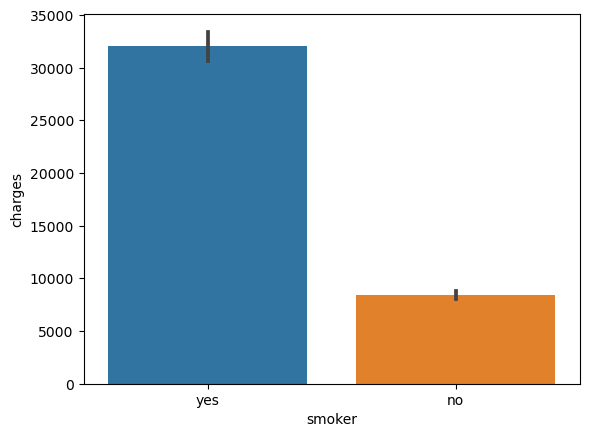

In [14]:
sns.barplot(data=df, x="smoker", y="charges");

## Are men more likely to smoke than women?

- Null Hypothesis: There is no significant relationship between sex and smoker status.

- Alternative Hypothesis: There is a significant relationship between sex and smoker status.

In [15]:
# Obtain the contingency table
table = pd.crosstab(df["sex"], df["smoker"])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [17]:
# Perform the test
result = stats.chi2_contingency(table)
_, p, _, _ = result

In [18]:
print(p)
p < 0.05

0.006548143503580696


True

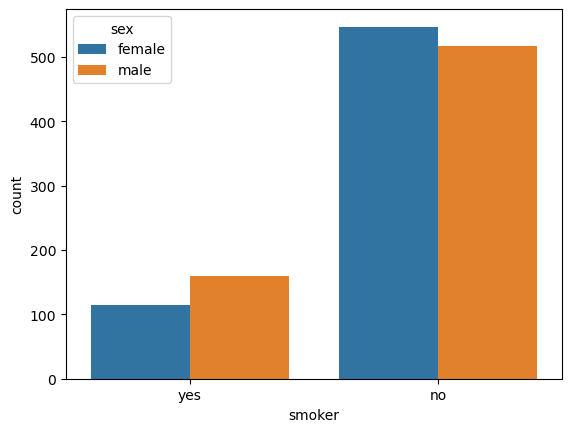

In [20]:
sns.countplot(data=df, x="smoker", hue="sex");

### Do different regions have different charges, on average?
- Null Hypothesis: On average, there is no significant difference in charges across regions.

- Alternative Hypothesis: On average, there is a significant difference in charges across regions.


In [21]:
# Define a dictionary with the regions
regions = {}

# Store the charge data from each region as a value and the region as the key
for region in df["region"].unique():
    data = df.loc[df["region"] == region, "charges"]
    regions[region] = data

# Show the keys
regions.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [22]:
# Check for outliers
for region in regions.keys():
    # Get the zscores for the specific region
    zscores = stats.zscore(regions[region])
    # Get the outliers for the region
    outliers = abs(zscores) > 3
    # Display how much outliers there are
    print(f"There are {outliers.sum()} outliers for the {region} region")

    # If there are outliers, remove them.
    if outliers.sum():
        print("Removing them.")
        regions[region] = regions[region].loc[~outliers]

There are 8 outliers for the southwest region
Removing them.
There are 2 outliers for the southeast region
Removing them.
There are 7 outliers for the northwest region
Removing them.
There are 4 outliers for the northeast region
Removing them.


In [23]:
# Create a dictionary for region normal test results
region_norm_results = {}

# Iterate through all the regions
for key, values in regions.items():
    stat, p = stats.normaltest(values)
    region_norm_results[key] = {
        "n": len(values),
        "p": p,
        "test stat": stat
    }

# Make into a DataFrame for easy viewing
region_norm_results_df = pd.DataFrame(region_norm_results).T
region_norm_results_df

,n,p,test stat
southwest,317.0,7.728611e-22,97.223886
southeast,362.0,1.936990e-13,58.544942
northwest,318.0,2.940543e-19,85.341045
northeast,320.0,3.557877e-17,75.749565


In [24]:
stats.levene(*regions.values())

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

The p-value is less than our alpha we we fail to reject our null hypothesis

#### Statistical Test

In [25]:
stats.kruskal(*regions.values())

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)

Since the p-value is greater than the alpha 0.05 we reject the null hypothesis and support the alternative hypothesis. 

In [26]:
tukeys_results = pairwise_tukeyhsd(df["charges"], df["region"])
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


The results above display a significant difference between the south east and south west. 

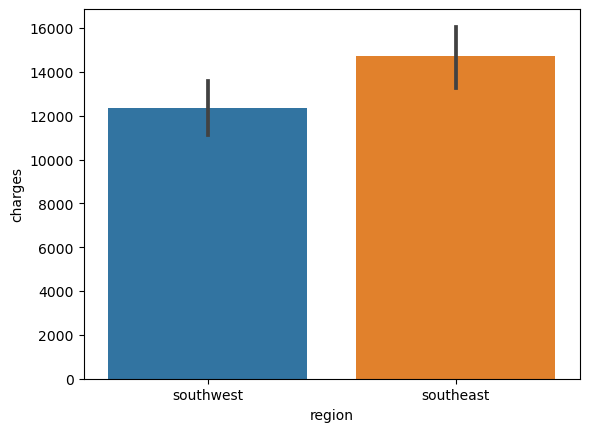

In [27]:
sns.barplot(data=df.loc[(df["region"] == "southwest") | (df["region"] == "southeast"), :], x="region", y="charges");

The visual above depicts that the southeast region is charged more than the southwest. 